# Introduction

# Exploratory Data Analysis

We first load the dataset from the CSV file to take a closer look on to the data. We'll look for missing values, review each variable's type and look at basic descriptions of each variable through statistics or plots depending if the variable is numeric or categorical.

Let's import the needed libraries.

In [47]:
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from datetime import datetime, timedelta
from locale import atof

%matplotlib inline

Load the data.

In [2]:
data = pd.read_csv('train.csv', sep=';', decimal=',')

See data column names.

In [3]:
data.columns

Index(['ID', 'TIMESTAMP', 'WEBSITE', 'GDS', 'DEPARTURE', 'ARRIVAL', 'ADULTS',
       'CHILDREN', 'INFANTS', 'TRAIN', 'HAUL_TYPE', 'DISTANCE', 'DEVICE',
       'TRIP_TYPE', 'PRODUCT', 'SMS', 'EXTRA_BAGGAGE', 'NO_GDS'],
      dtype='object')

See how many missing values the dataset has.

In [4]:
data.isnull().sum()

ID                 0
TIMESTAMP          0
WEBSITE            0
GDS                0
DEPARTURE          0
ARRIVAL            0
ADULTS             0
CHILDREN           0
INFANTS            0
TRAIN              0
HAUL_TYPE          0
DISTANCE           0
DEVICE           133
TRIP_TYPE          0
PRODUCT            0
SMS                0
EXTRA_BAGGAGE      0
NO_GDS             0
dtype: int64

There are very few missing values, only in variable 'DEVICE'.

See distribution of classes in target variable.

In [5]:
data['EXTRA_BAGGAGE'].value_counts()

False    40201
True      9799
Name: EXTRA_BAGGAGE, dtype: int64

IMPORTANT: Classes are imbalanced. There are much more samples belonging to the 'False' class than to the 'True' 
class.

Review date variables: 'TIMESTAMP', 'DEPARTURE' and 'ARRIVAL'.

In [6]:
date_columns = ['TIMESTAMP', 'DEPARTURE', 'ARRIVAL']
print(data[date_columns].head())

for i in range(0, len(date_columns)):
    print(date_columns[i] + " type:", data[date_columns[i]].dtype)

  TIMESTAMP  DEPARTURE    ARRIVAL
0   01/July    22/July    25/July
1   01/July    29/July    29/July
2   01/July    29/July  19/August
3   01/July    24/July  04/August
4   01/July  11/August  11/August
TIMESTAMP type: object
DEPARTURE type: object
ARRIVAL type: object


These variables don't have the correct type, for now we'll ignore this because we'll later transform this variables.

Review categorical variables: 'DEVICE', 'HAUL_TYPE', 'TRIP_TYPE', 'PRODUCT' and 'WEBSITE'.

In [7]:
categorical_columns = ['DEVICE', 'HAUL_TYPE', 'TRIP_TYPE', 'PRODUCT', 'WEBSITE']
print(data[categorical_columns].head())

for i in range(0, len(categorical_columns)):
    print(categorical_columns[i] + " type:", data[categorical_columns[i]].dtype)

       DEVICE    HAUL_TYPE          TRIP_TYPE PRODUCT WEBSITE
0      TABLET     DOMESTIC         ROUND_TRIP    TRIP    EDES
1  SMARTPHONE  CONTINENTAL            ONE_WAY    TRIP    EDIT
2      TABLET  CONTINENTAL         ROUND_TRIP    TRIP    OPUK
3  SMARTPHONE     DOMESTIC  MULTI_DESTINATION    TRIP    OPIT
4    COMPUTER  CONTINENTAL            ONE_WAY    TRIP    EDES
DEVICE type: object
HAUL_TYPE type: object
TRIP_TYPE type: object
PRODUCT type: object
WEBSITE type: object


These variables don't have the correct type, we'll transform them to categorical variables. 

IMPORTANT: We are not sure, all levels of each categorical variable are present in the given train dataset. For simplicity we'll assume they all are.

In [8]:
data['WEBSITE'] = pd.Series(data['WEBSITE'], dtype="category").values

data['DEVICE'] = pd.Series(data['DEVICE'], dtype="category").values

data['HAUL_TYPE'] = pd.Series(data['HAUL_TYPE'], dtype="category").values

data['TRIP_TYPE'] = pd.Series(data['TRIP_TYPE'], dtype="category").values

data['PRODUCT'] = pd.Series(data['PRODUCT'], dtype="category").values

for i in range(0, len(categorical_columns)):
    print(categorical_columns[i] + " type:", data[categorical_columns[i]].dtype)

DEVICE type: category
HAUL_TYPE type: category
TRIP_TYPE type: category
PRODUCT type: category
WEBSITE type: category


Lets review the frequencies of each level of each categorical variable with respect to the target variable 'EXTRA_BAGGAGE'.

In [ ]:
ct = pd.crosstab(data.WEBSITE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

In [ ]:
ct = pd.crosstab(data.DEVICE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

In [ ]:
ct = pd.crosstab(data.HAUL_TYPE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.show()

In [ ]:
ct = pd.crosstab(data.TRIP_TYPE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.show()

In [ ]:
ct = pd.crosstab(data.PRODUCT, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.show()

Review boolean variables: 'TRAIN' and 'SMS'.

In [9]:
boolean_columns = ['TRAIN', 'SMS']
print(data[boolean_columns].head())

for i in range(0, len(boolean_columns)):
    print(boolean_columns[i] + " type:", data[boolean_columns[i]].dtype)

   TRAIN    SMS
0  False   True
1  False  False
2  False   True
3  False  False
4  False  False
TRAIN type: bool
SMS type: bool


Variables have their expected type.

Review numeric variables: 'GDS', 'NO_GDS', 'ADULTS', 'CHILDREN' and 'INFANTS' as discrete, and 'DISTANCE' as continuous.

In [10]:
numeric_columns = ['GDS', 'NO_GDS', 'ADULTS', 'CHILDREN', 'INFANTS', 'DISTANCE']
print(data[numeric_columns].head())

for i in range(0, len(numeric_columns)):
    print(numeric_columns[i] + " type:", data[numeric_columns[i]].dtype)

   GDS  NO_GDS  ADULTS  CHILDREN  INFANTS  DISTANCE
0    1       0       1         0        0   628.844
1    0       1       1         0        0  1281.430
2    2       0       1         0        0  1730.350
3    0       2       1         0        0   652.702
4    0       1       1         0        0  1717.850
GDS type: int64
NO_GDS type: int64
ADULTS type: int64
CHILDREN type: int64
INFANTS type: int64
DISTANCE type: float64


Variables have their expected type. Let's review some statistics related to these numeric variables.

In [11]:
data[numeric_columns].describe()

,GDS,NO_GDS,ADULTS,CHILDREN,INFANTS,DISTANCE
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,0.642420,0.591340,1.488240,0.09910,0.018160,2200.182573
std,0.581828,0.642328,0.828755,0.38931,0.135759,2558.688601
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.00000,0.000000,788.826000
50%,1.000000,1.000000,1.000000,0.00000,0.000000,1317.955000
75%,1.000000,1.000000,2.000000,0.00000,0.000000,2110.260000
max,4.000000,4.000000,9.000000,5.00000,2.000000,19766.100000


Everything seems to be correct and these numeric variables seem to have reasonable min and max values.

As a final exploratory step, we'll plot the correlation between variables in a heatmap.

In [12]:
def plot_correlation_heatmap(data):
    # Compute the correlation matrix
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.show()

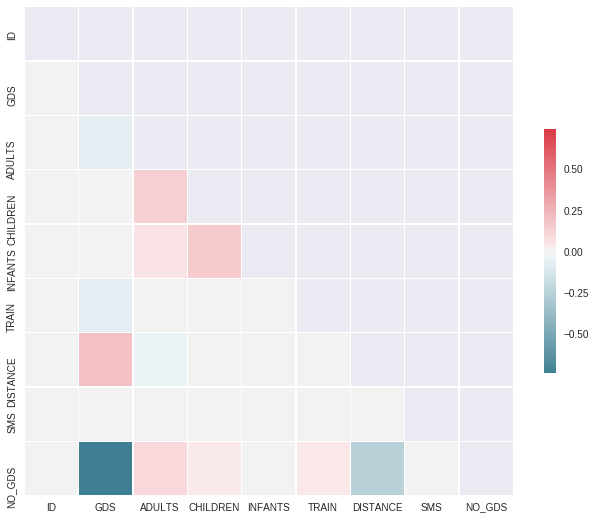

In [13]:
plot_correlation_heatmap(data.drop('EXTRA_BAGGAGE', 1))

The plot shows relatively low correlation values between variables. The highest negative correlation is between 'GDS' and 'NO_GDS' variables, which is expected, because as the number of flights bought through the GDS increases, the number of flights bought though other channels decreases.

# Data Cleaning

Now we'll clean our dataset in order to be ready to be used for modeling and predicting. We'll start by dealing with the missing values, followed by perfoming some transformations to the original variables.

As we mentioned above, the only variable that has missing values is the 'DEVICE' variable. Since it has very few missing values, with respect to the dataset size we'll just remove them. If there were much more we could use different imputation methods to fill this missing values:

- For numeric variables we could perform a simple imputation of the mean, mode or median value of the column. In case the variable is categorical we could impute the most frequent level of the variable.
- Another more complex option is to estimate the missing value with the help of regression, ANOVA, logistic regression or another modelling technique.
- We could also fill missing values using similarities between samples using algorithms like K-Nearest Neighbors.

In [14]:
data = data[pd.notnull(data['DEVICE'])]
data = data.reset_index(drop=True)

print(data.isnull().sum())

ID               0
TIMESTAMP        0
WEBSITE          0
GDS              0
DEPARTURE        0
ARRIVAL          0
ADULTS           0
CHILDREN         0
INFANTS          0
TRAIN            0
HAUL_TYPE        0
DISTANCE         0
DEVICE           0
TRIP_TYPE        0
PRODUCT          0
SMS              0
EXTRA_BAGGAGE    0
NO_GDS           0
dtype: int64


Now we see there are no more missing values in the dataset.

Later we drop the 'ID' variable since it is useless for our analysis.

In [15]:
data = data.drop('ID', 1)
data = data.reset_index(drop=True)

All date variables have the same format 'day_number/month_name'. We'll transform these values to numeric values corresponding to number of week in year that the date belongs to.

In [16]:
# Function that transforms date into value corresponding to number of week in year that it belongs to. We'll assume
# dates correspond to this year 2017.
def day_to_week_of_year(date_to_transform):
    return datetime.strptime(date_to_transform + "/2017", '%d/%B/%Y').isocalendar()[1]

In [17]:
data['TIMESTAMP'] = data['TIMESTAMP'].apply(day_to_week_of_year)
data['DEPARTURE'] = data['DEPARTURE'].apply(day_to_week_of_year)
data['ARRIVAL'] = data['ARRIVAL'].apply(day_to_week_of_year)

print(data[date_columns].head())

for i in range(0, len(date_columns)):
    print(date_columns[i] + " type:", data[date_columns[i]].dtype)

   TIMESTAMP  DEPARTURE  ARRIVAL
0         26         29       30
1         26         30       30
2         26         30       33
3         26         30       31
4         26         32       32
TIMESTAMP type: int64
DEPARTURE type: int64
ARRIVAL type: int64


Now we can see date variables are transformed to numeric discrete values.

As for the categorical variables, we'll try out two types of transformations:

- Using the LabelEncoder that transforms each level of the categorical variable to a discrete numeric value.

In [18]:
data_encoded = data.copy()

label_encoder = LabelEncoder()

data_encoded['WEBSITE'] = pd.Series(label_encoder.fit_transform(data_encoded['WEBSITE'])).values

data_encoded['DEVICE'] = pd.Series(label_encoder.fit_transform(data_encoded['DEVICE'])).values

data_encoded['HAUL_TYPE'] = pd.Series(label_encoder.fit_transform(data_encoded['HAUL_TYPE'])).values

data_encoded['TRIP_TYPE'] = pd.Series(label_encoder.fit_transform(data_encoded['TRIP_TYPE'])).values

data_encoded['PRODUCT'] = pd.Series(label_encoder.fit_transform(data_encoded['PRODUCT'])).values

print(data_encoded[categorical_columns].head())

for i in range(0, len(categorical_columns)):
    print(categorical_columns[i] + " type:", data_encoded[categorical_columns[i]].dtype)

   DEVICE  HAUL_TYPE  TRIP_TYPE  PRODUCT  WEBSITE
0       3          1          2        1       11
1       2          0          1        1       18
2       3          0          2        1       54
3       2          1          0        1       50
4       0          0          1        1       11
DEVICE type: int64
HAUL_TYPE type: int64
TRIP_TYPE type: int64
PRODUCT type: int64
WEBSITE type: int64


We save the new cleaned and encoded data into a new CSV file called 'clean_encoded_train.csv'.

In [19]:
data_encoded.to_csv('clean_encoded_train.csv', index=False, sep=';')

- Using the LabelBinarizer that transforms a categorical variable to multiple binary variables, as much as the number of levels of the original categorical variable.

For this case, we won't binarize 'WEBSITE' variable because it has too many levels. For this variable we'll use the previous LabelEncoder.

After transforming the original categorical variable, we'll drop the original one and only keep the new binarized variables.

In [21]:
data_binarized = data.copy()

label_encoder = LabelEncoder()

data_binarized['WEBSITE'] = pd.Series(label_encoder.fit_transform(data_binarized['WEBSITE'])).values

label_encoder = LabelBinarizer()

encoder_result = label_encoder.fit_transform(data_binarized['DEVICE'])
bin_device_columns = ["DEVICE_" + str(bin_class) for bin_class in label_encoder.classes_]
data_device = pd.DataFrame(encoder_result, columns=bin_device_columns)
data_binarized = data_binarized.drop('DEVICE', 1)
data_binarized = data_binarized.reset_index(drop=True)
data_binarized = pd.concat([data_binarized, data_device], axis=1)
data_binarized = data_binarized.reset_index(drop=True)

encoder_result = label_encoder.fit_transform(data_binarized['HAUL_TYPE'])
bin_haul_type_columns = ["HAUL_TYPE_" + str(bin_class) for bin_class in label_encoder.classes_]
data_haul_type = pd.DataFrame(encoder_result, columns=bin_haul_type_columns)
data_binarized = data_binarized.drop('HAUL_TYPE', 1)
data_binarized = data_binarized.reset_index(drop=True)
data_binarized = pd.concat([data_binarized, data_haul_type], axis=1)
data_binarized = data_binarized.reset_index(drop=True)

encoder_result = label_encoder.fit_transform(data_binarized['TRIP_TYPE'])
bin_trip_type_columns = ["TRIP_TYPE_" + str(bin_class) for bin_class in label_encoder.classes_]
data_trip_type = pd.DataFrame(encoder_result, columns=bin_trip_type_columns)
data_binarized = data_binarized.drop('TRIP_TYPE', 1)
data_binarized = data_binarized.reset_index(drop=True)
data_binarized = pd.concat([data_binarized, data_trip_type], axis=1)
data_binarized = data_binarized.reset_index(drop=True)

encoder_result = label_encoder.fit_transform(data_binarized['PRODUCT'])
data_product = pd.Series(encoder_result[:, 0], name='PRODUCT')
data_binarized = data_binarized.drop('PRODUCT', 1)
data_binarized = data_binarized.reset_index(drop=True)
data_binarized = pd.concat([data_binarized, data_product], axis=1)
data_binarized = data_binarized.reset_index(drop=True)

binarized_categorical_columns = list()
binarized_categorical_columns += list(bin_device_columns)
binarized_categorical_columns += list(bin_haul_type_columns)
binarized_categorical_columns += list(bin_trip_type_columns)
binarized_categorical_columns += list(['PRODUCT'])

print(data_binarized[binarized_categorical_columns].head())

for i in range(0, len(binarized_categorical_columns)):
    print(binarized_categorical_columns[i] + " type:", data_binarized[binarized_categorical_columns[i]].dtype)

   DEVICE_COMPUTER  DEVICE_OTHER  DEVICE_SMARTPHONE  DEVICE_TABLET  \
0                0             0                  0              1   
1                0             0                  1              0   
2                0             0                  0              1   
3                0             0                  1              0   
4                1             0                  0              0   

   HAUL_TYPE_CONTINENTAL  HAUL_TYPE_DOMESTIC  HAUL_TYPE_INTERCONTINENTAL  \
0                      0                   1                           0   
1                      1                   0                           0   
2                      1                   0                           0   
3                      0                   1                           0   
4                      1                   0                           0   

   TRIP_TYPE_MULTI_DESTINATION  TRIP_TYPE_ONE_WAY  TRIP_TYPE_ROUND_TRIP  \
0                            0                 

We save the new cleaned and binarized data into a new CSV file called 'clean_binarized_train.csv'.

In [22]:
data_binarized.to_csv('clean_binarized_train.csv', index=False, sep=';')

# Baseline Model

We'll try out a quick test with each clean dataset (encoded and binarized) and a simple classification model such as 'Logistic Regression' to see how the model performs. We'll split the data into training and test data, we'll train the model using the training data and the model's default parameters. For now we won't perform any grid-search to perform hyper-parameter tunning or any nested cross-validation to obtain a generalization score.

We'll use the test data to evaluate the previous model with the F1 score and we'll plot the confussion matrix to visually understand better the model's performance.

In [23]:
# Function that evaluates model using F1 score
def evaluate_model(best_estimator, X_test, y_test):
    y_pred = best_estimator.predict(X_test)    
    
    f1_eval_score = f1_score(y_test, y_pred, average='weighted')
    
    print("##### F1 Score:", f1_eval_score)
    print()
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['False', 'True'], title='Confusion matrix', cmap=plt.cm.Purples)
    

# Function to plot confussion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Purples):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    plt.show()

### Cleaned Encoded Data:

In [24]:
# Load encoded data
data_encoded = pd.read_csv('clean_encoded_train.csv', sep=';', decimal='.')

In [25]:
# Split data to separate 'y' and 'X'.
de_y = data_encoded['EXTRA_BAGGAGE']

# Drop target variable from X DataFrame
de_X = data_encoded.drop('EXTRA_BAGGAGE', 1)

Split data into training and test datasets, asumming the 'test.csv' data is future data and the 'train.csv' data is the only one we have available.

We'll use the 'stratify' option since previously we saw the target variable was imbalanced and we want to keep the distribution of each class in both datasets.

In [26]:
de_X_train, de_X_test, de_y_train, de_y_test = train_test_split(de_X, de_y, test_size=0.3, random_state=875146, stratify=de_y)

In [27]:
de_baseline = LogisticRegression(random_state=621473)

de_baseline.fit(de_X_train, de_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=621473, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

##### F1 Score: 0.723564378805



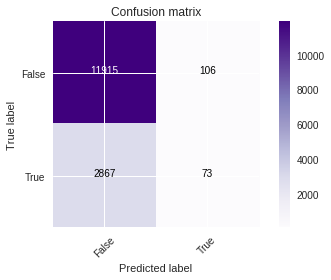

In [28]:
evaluate_model(de_baseline, de_X_test, de_y_test)

Even though we said we were going to use only the default parameters of the LogisticRegression model, we must consider using the 'class_weight' parameter. If we don't specify an option, the model assumes all classes have the same weight equal to one. Since we know a priori, our samples are imbalanced with respect to the response variable, the 'balanced' option automatically adjusts the weights of each sample inversely proportional to the class frequencies in the input data. Taking this into consideration, we train the model again with this option and see the results.

In [29]:
de_baseline = LogisticRegression(class_weight='balanced', random_state=621473)

de_baseline.fit(de_X_train, de_y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=621473,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

##### F1 Score: 0.661398201492



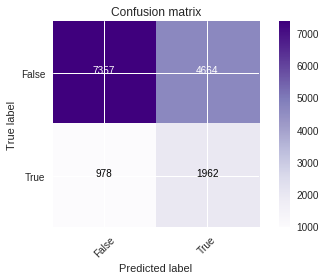

In [30]:
evaluate_model(de_baseline, de_X_test, de_y_test)

OJO! Decir algo sobre la diferencia entre scores y CM

### Cleaned Binarized Data:

In [31]:
# Load binarized data
data_binarized = pd.read_csv('clean_binarized_train.csv', sep=';', decimal='.')

In [32]:
# Split data to separate 'y' and 'X'.
db_y = data_binarized['EXTRA_BAGGAGE']

# Drop target variable from X DataFrame
db_X = data_binarized.drop('EXTRA_BAGGAGE', 1)

In [33]:
db_X_train, db_X_test, db_y_train, db_y_test = train_test_split(db_X, db_y, test_size=0.3, random_state=875146, stratify=db_y)

In [34]:
db_baseline = LogisticRegression(class_weight='balanced', random_state=621473)

db_baseline.fit(db_X_train, db_y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=621473,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

##### F1 Score: 0.660703074502



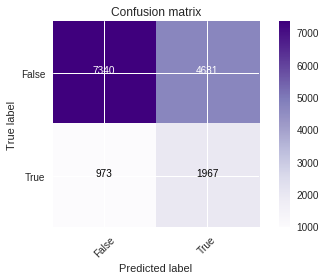

In [35]:
evaluate_model(db_baseline, db_X_test, db_y_test)

So we see that we obtain almost the same F1 score for both datasets. The encoded has a slightly better performance score so for further analysis we'll keep using this dataset.

# Feature Engineering

Feature engineering is the process of creating new variables from the existing raw features in order to increase the predictive power of the learning algorithms. In fact, during the cleaning process, having transformed the categorical variables to discrete or binary variables is already considered as feature engineering, this process is specifically known as 'factorization' of a categorical feature, but we did it earlier to test our data and create a first baseline model to comapre with. Another common feature engineering technique is called 'binning', which consists of 'cutting' values of a continuous variable into 'bins' so it becomes a categorical variable.

For this exercise we'll create three new variables using pre-existing variables from the original dataset.

In [36]:
# Load original data
original_data = pd.read_csv('train.csv', sep=';', decimal=',')

### TRIP_DAYS Feature

This feature will be created using the 'DEPARTURE' and 'ARRIVAL' variables. It will represent the duration in days of the trip. We'll assume 'DEPARTURE' dates corresponde to the current year 2017. If the month of the 'ARRIVAL' date is smaller than the one in the 'DEPARTURE' date, we'll assume this date corresponds to next year 2018.

In [37]:
def calculate_trip_days(row):
    departure_date = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    arrival_date = datetime.strptime(row['ARRIVAL'] + "/2017", '%d/%B/%Y')
    
    if arrival_date.month < departure_date.month:
        arrival_date = datetime.strptime(row['ARRIVAL'] + "/2018", '%d/%B/%Y')
    
    trip_days = arrival_date - departure_date
    
    return trip_days.days

trip_days = original_data.apply(lambda row: calculate_trip_days(row), axis=1)
trip_days = trip_days[pd.notnull(original_data['DEVICE'])]
trip_days = trip_days.reset_index(drop=True)

data_encoded['TRIP_DAYS'] = trip_days

print(data_encoded['TRIP_DAYS'].head())

0     3
1     0
2    21
3    11
4     0
Name: TRIP_DAYS, dtype: int64


### PLANNING_DAYS Feature

This feature will be created using the 'TIMESTAMP' and 'DEPARTURE' variables. It will represent how many days ahead of the departure date, the trip was planned, starting from the day the plane tickets were bought.

In [38]:
def calculate_planning_days(row):
    buy_date = datetime.strptime(row['TIMESTAMP'] + "/2017", '%d/%B/%Y')
    departure_date = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    
    if departure_date.month < buy_date.month:
        departure_date = datetime.strptime(row['DEPARTURE'] + "/2018", '%d/%B/%Y')
    
    planning_days = departure_date - buy_date
    
    return planning_days.days

planning_days = original_data.apply(lambda row: calculate_planning_days(row), axis=1)
planning_days = planning_days[pd.notnull(original_data['DEVICE'])]
planning_days = planning_days.reset_index(drop=True)

data_encoded['PLANNING_DAYS'] = planning_days

print(data_encoded['PLANNING_DAYS'].head())

0    21
1    28
2    28
3    23
4    41
Name: PLANNING_DAYS, dtype: int64


### WEEKEND_DAYS Feature

This feature will be created using the 'DEPARTURE' and 'ARRIVAL' variables. It will represent how many weekend days are included in the duration of the trip.

In [39]:
def calculate_weekend_days(row):
    aux = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    arrival_date = datetime.strptime(row['ARRIVAL'] + "/2017", '%d/%B/%Y')
    
    if arrival_date.month < aux.month:
        arrival_date = datetime.strptime(row['ARRIVAL'] + "/2018", '%d/%B/%Y')
    
    weekend_days = 0
    
    while (aux <= arrival_date):
        if (aux.weekday() > 4):
            weekend_days += 1
            
        aux = aux + timedelta(days=1)
    
    return weekend_days

weekend_days = original_data.apply(lambda row: calculate_weekend_days(row), axis=1)
weekend_days = weekend_days[pd.notnull(original_data['DEVICE'])]
weekend_days = weekend_days.reset_index(drop=True)

data_encoded['WEEKEND_DAYS'] = weekend_days

print(data_encoded['WEEKEND_DAYS'].head())

0    2
1    1
2    7
3    2
4    0
Name: WEEKEND_DAYS, dtype: int64


We think this kind of variables can give more explicit information to the model in order to perform a better discrimination between passengers that buy or not an extra baggage on their trip. We'll save this new dataset into a separate CSV file called 'clean_enriched_train.csv'

In [40]:
data_encoded.to_csv('cleaned_enriched_train.csv', index=False, sep=';')

Now we'll try this new data with our baseline LigisticRegression model to see if our new features improve the model's performance score.

In [41]:
# Load enriched data
data_enriched = pd.read_csv('cleaned_enriched_train.csv', sep=';', decimal='.')

In [42]:
# Split data to separate 'y' and 'X'.
den_y = data_enriched['EXTRA_BAGGAGE']

# Drop target variable from X DataFrame
den_X = data_enriched.drop('EXTRA_BAGGAGE', 1)

In [43]:
den_X_train, den_X_test, den_y_train, den_y_test = train_test_split(den_X, den_y, test_size=0.3, random_state=875146, stratify=den_y)

In [44]:
den_baseline = LogisticRegression(class_weight='balanced', random_state=621473)

den_baseline.fit(den_X_train, den_y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=621473,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

##### F1 Score: 0.66602222214



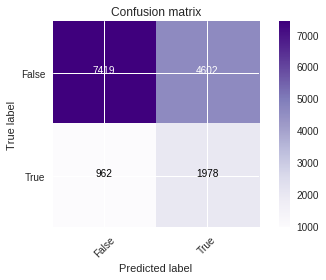

In [45]:
evaluate_model(den_baseline, den_X_test, den_y_test)

The enriched data improves the model's performance score by a very small fraction, so from now on we will use these new enriched data for further experiments.

# Model Selection and Evaluation

In this section we'll test various classification algorithms with the same data (enriched) to compare their performance scores. In order to get the most accurate generalization score (most close to reality) of a model, with the least bias, at the same time we choose the best hyper-parameters, we must perform nested cross-validation. The outer corss-validation will be used to assess the performance of the model. For each of this outer folds we'll perform the inner cross-validations that will be used to determine the hyper-parameters in each fold.

More of nested cross-validation can be seen in this paper: Gavin C. Cawley, Nicola L. C. Talbot, "On Over-fitting in Model Selection and Subsequent Selection Bias in Performance Evaluation", JMLR 11(Jul):2079−2107, 2010 http://jmlr.csail.mit.edu/papers/v11/cawley10a.html

Once we identify the model with the highest generalization score, we re-execute only the inner cross-validation process that performs grid-search along with cross-validation to find the best configuration of hyper-parameters for that model and obtained a unique model trained with the whole trining dataset. In practice the cross-validation score obtained for this model will be slightly differ from the one obtained in the previous nested cross-validation process. We do the latter in order to be aware of the 'real' generalization score obtained without bias.

This model will be the one we'll test with new unseed future data, in this case, the given 'test.csv' data.

We'll make use of an important sklearn's class called 'Pipeline', tha sequentially applies a list of transformers to the data and finally applies and estimator model. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For all models we'll use a VarianceThreshold transformer followed by a StandardScaler transformer before the classification estimator.

The VarianceThreshold bassically removed useless features that have zero variance.

The StandardScaler, as it's name states, standardizes each column to have zero mean and unit variance. This step is important since we are dealing with features with different measurement units, and we don't want the estimator to give more importance to features with higher values because they're not standardized.

# Logistic Regression

We first start by trying out again the LogistiRegression classifier but performing hyper-parameter tunning for the penalization parameter 'C'. This parameter represents the inverse of regularization strength. Similar to SVM's the smaller the values, the stronger the regularization.

In [48]:
# Load cleaned enriched data
data_type = 'clean_enriched'
data = pd.read_csv(data_type + '_train.csv', sep=';', decimal='.')

In [49]:
# Split data to separate 'y' and 'X'.
y = data['EXTRA_BAGGAGE']

# Drop target variable from X DataFrame
X = data.drop('EXTRA_BAGGAGE', 1)

In [ ]:
lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(lr_nested_cv_f1_scores, data_type + '_lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(lr_nested_cv_f1_scores), "std =", np.std(lr_nested_cv_f1_scores))
print()

The previous execution gives the following F1 generalization score:

##### Generalization F1 Score: mean = 0.668949634197 std = 0.00667454322097

We'll also plot the outer cross-validation scores in a boxplot to assess the model's statibility. If there are very few or no outlierts, this is a good sign that the model is stable. Since we have a small standard deviation we expect to have no outliers in the boxplot.

In [57]:
# Function to plot boxplot of nested cross-validation scores.
def plot_cv_scores(cv_scores):
    sns.set_style("whitegrid")
    
    ax = sns.boxplot(x=cv_scores, orient="v")
    
    plt.ylim(0, 1) 
    plt.show()

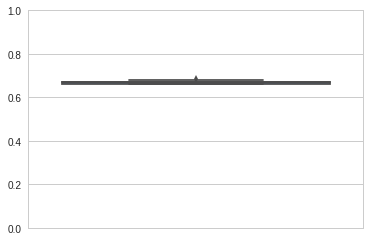

In [58]:
lr_nested_cv_f1_scores = joblib.load(data_type + '_lr_nested_cv_f1_scores.pkl')

plot_cv_scores(lr_nested_cv_f1_scores)

# Linear SVM

As a second linear classification model we'll try LinearSVC classifier, performing hyper-parameter tunning for the penalization parameter 'C'. This parameter represents penalty given to the error term. The smaller the values, the stronger the regularization.

In [ ]:
linear_svm_pipe = Pipeline([('variance', VarianceThreshold()),
                            ('scaler', StandardScaler()),
                            ('linear_svm', LinearSVC(penalty='l1', dual=False, random_state=123456, class_weight='balanced'))])

param_grid = dict()
param_grid['linear_svm__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(linear_svm_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

linear_svm_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(linear_svm_nested_cv_f1_scores, data_type + '_linear_svm_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(linear_svm_nested_cv_f1_scores), "std =", np.std(linear_svm_nested_cv_f1_scores))
print()

The F1 generalization score is shown below:

##### Generalization F1 Score: mean = 0.667330992787 std = 0.00671589397452

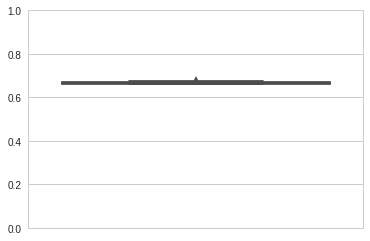

In [59]:
linear_svm_nested_cv_f1_scores = joblib.load(data_type + '_linear_svm_nested_cv_f1_scores.pkl')

plot_cv_scores(linear_svm_nested_cv_f1_scores)

The resulting boxplot of the outer cross-validation scores still shows model stability even though the feneralization score obtained was a bit lower than the one obtained with LogisticRegression.

# Random Forest

Finally we test a non-linear ensemble method called the RandomForestClassifier. We change the default value for the 'max_features' paranmeter to use a common rule of thumb, the 'sqrt' option. This parameter represents the number of features to consider when looking for the best split in a tree.

We perform hyper-parameter tunning of several important parameters such as:

- n_estimators: this parameter represents the number of trees we want to build before taking the maximum voting or averages of predictions. The higher the number of trees the more stronger and stable the predictions will be.
- max_depth: this parameter represents the maximum depth of each tree.
- min_samples_leaf: this parameter represents the minimum number of samples to consider in a leaf of a tree. A smaller leaf makes the model more prone to capturing noise in the training data.

In [ ]:
rf_pipe = Pipeline([('variance', VarianceThreshold()),
                            ('scaler', StandardScaler()),
                            ('rf', RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=573146, class_weight='balanced'))])

param_grid = dict()
param_grid['rf__n_estimators'] = list(range(200, 1200, 150))
param_grid['rf__max_depth'] = [10, 20, 30]
param_grid['rf__min_samples_leaf'] = [50, 60, 70, 80, 90, 100]


inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(rf_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

rf_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(rf_nested_cv_f1_scores, 'rf_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(rf_nested_cv_f1_scores), "std =", np.std(rf_nested_cv_f1_scores))
print()